# T81-558: Applications of Deep Neural Networks
**Module 13: Advanced/Other Topics**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 13.1: Neural Networks with Ensembles for TensorFlow and Keras](https://www.youtube.com/watch?v=RVIGVkj5aXo&index=38&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 13.2: Neural Networks with Ensembles for TensorFlow and Keras](https://www.youtube.com/watch?v=RVIGVkj5aXo&index=38&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

Weekly video update:

* *Will be posted week of this class*

Tonight I will cover several advanced features of TensorFlow.  This is mostly a collection of additional topics that did not fit nicely into other sections of the course.  Topics include:

* Multi-Output Regression
* Autoencoders
* Python Image Handling
* Image Autoencoders
* Denoising Autoencoders

# Helpful Functions

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Function Approximation


Using TensorFlow backend.


Actual
[[ 0.00071864]
 [ 0.01803382]
 [ 0.11465593]
 [ 0.1213861 ]
 [ 0.1712333 ]]
Pred
[[ 0.00108178]
 [ 0.0176986 ]
 [ 0.11498825]
 [ 0.12097581]
 [ 0.17125519]]


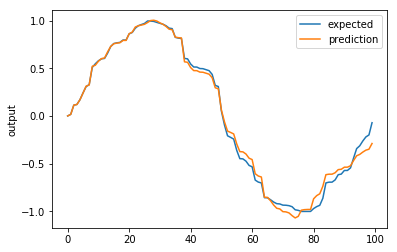

In [2]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.sin(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)

pred = model.predict(x)

print("Actual")
print(y[0:5])

print("Pred")
print(pred[0:5])

chart_regression(pred.flatten(),y,sort=False)

# Multi-Output Regression

Unlike most models, neural networks can provide multiple regression outputs.  This allows a neural network to generate multiple outputs for the same input.  For example, the MPG data set might be trained to predict both MPG and horsepower.  One area that multiple regression outputs can be useful for is auto encoders.  The following diagram shows a multi-regression neural network.  As you can see, there are multiple output neurons.  Usually multiple output neurons are used for classification.  However, in this case it is a regression neural network.

![Multi-Output Regression](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_multi_output.png "Multi-Output Regression")

The following program uses a multi-output regression to predict both [sin](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) and [cos](https://en.wikipedia.org/wiki/Trigonometric_functions#Sine.2C_cosine_and_tangent) from the same input data.

In [3]:
from sklearn import metrics

rng = np.random.RandomState(1)
x = np.sort((360 * rng.rand(100, 1)), axis=0)
y = np.array([np.pi * np.sin(x*(np.pi/180.0)).ravel(), np.pi * np.cos(x*(np.pi/180.0)).ravel()]).T

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2)) # Two output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,batch_size=len(x),epochs=25000)


# Fit regression DNN model.
pred = model.predict(x)

score = np.sqrt(metrics.mean_squared_error(pred, y))
print("Score (RMSE): {}".format(score))

np.set_printoptions(suppress=True)

print("Predicted:")
print(np.array(pred[20:25]))

print("Expected:")
print(np.array(y[20:25]))


Score (RMSE): 0.06828818936768069
Predicted:
[[ 2.72946334  1.59749806]
 [ 2.77023315  1.52115381]
 [ 2.86349416  1.21939802]
 [ 2.96225262  1.00497425]
 [ 3.01521635  0.88997185]]
Expected:
[[ 2.70765313  1.59317888]
 [ 2.75138445  1.51640628]
 [ 2.89299999  1.22480835]
 [ 2.97603942  1.00637655]
 [ 3.01381723  0.88685404]]


# Simple Auto Encoder

An auto encoder is a neural network that has the same number of input neurons as it does outputs.  The hidden layers of the neural network will have fewer neurons than the input/output neurons.  Because there are fewer neurons, the auto-encoder must learn to encode the input to the fewer hidden neurons.  The predictors (x) and output (y) are exactly the same in an auto encoder.  Because of this, auto encoders are said to be unsupervised.  

![Simple Auto Encoder](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_13_auto_encode.png "Simple Auto Encoder")

The following program demonstrates a very simple auto encoder that learns to encode a sequence of numbers.  Fewer hidden neurons will make it much more difficult for the auto encoder to learn.

In [4]:
from sklearn import metrics
import numpy as np
import pandas as pd
from IPython.display import display, HTML 
import tensorflow as tf

x = np.array([range(10)]).astype(np.float32)
print(x)

model = Sequential()
model.add(Dense(3, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,x,verbose=0,epochs=1000)

pred = model.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,x))
print("Fold score (RMSE): {}".format(score))
np.set_printoptions(suppress=True)
print(pred)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]]
Fold score (RMSE): 0.8201552033424377
[[-0.00129953  1.00072622  2.00759482  3.02428484  4.06089258  5.31815624
   6.42989349  7.32697964  8.62530708  6.56315136]]


# Reading Images in Python

We will make use of images to demonstrate auto encoders.  To use images in Python, we will make use of the Pillow package.  This package can be installed with the following command.  

```
pip install pillow
```

The following program uses Pillow to load and display an image.

[[[ 86 133 177]
  [ 85 132 176]
  [ 84 133 176]
  ..., 
  [ 94 128 153]
  [ 91 128 155]
  [ 94 129 169]]

 [[ 86 133 177]
  [ 88 135 179]
  [ 88 137 180]
  ..., 
  [ 96 133 159]
  [ 92 136 165]
  [ 99 141 183]]

 [[ 83 130 174]
  [ 87 134 178]
  [ 89 138 181]
  ..., 
  [108 150 175]
  [100 149 179]
  [ 97 144 186]]

 ..., 
 [[127  77  76]
  [131  81  80]
  [128  80  76]
  ..., 
  [  4  10  10]
  [  2  11  10]
  [  2  11  10]]

 [[132  81  77]
  [129  80  75]
  [124  75  70]
  ..., 
  [  4  10  10]
  [  3  12  11]
  [  3  12  11]]

 [[140  90  83]
  [137  87  80]
  [130  81  74]
  ..., 
  [ 11  17  17]
  [ 10  19  18]
  [ 10  19  18]]]


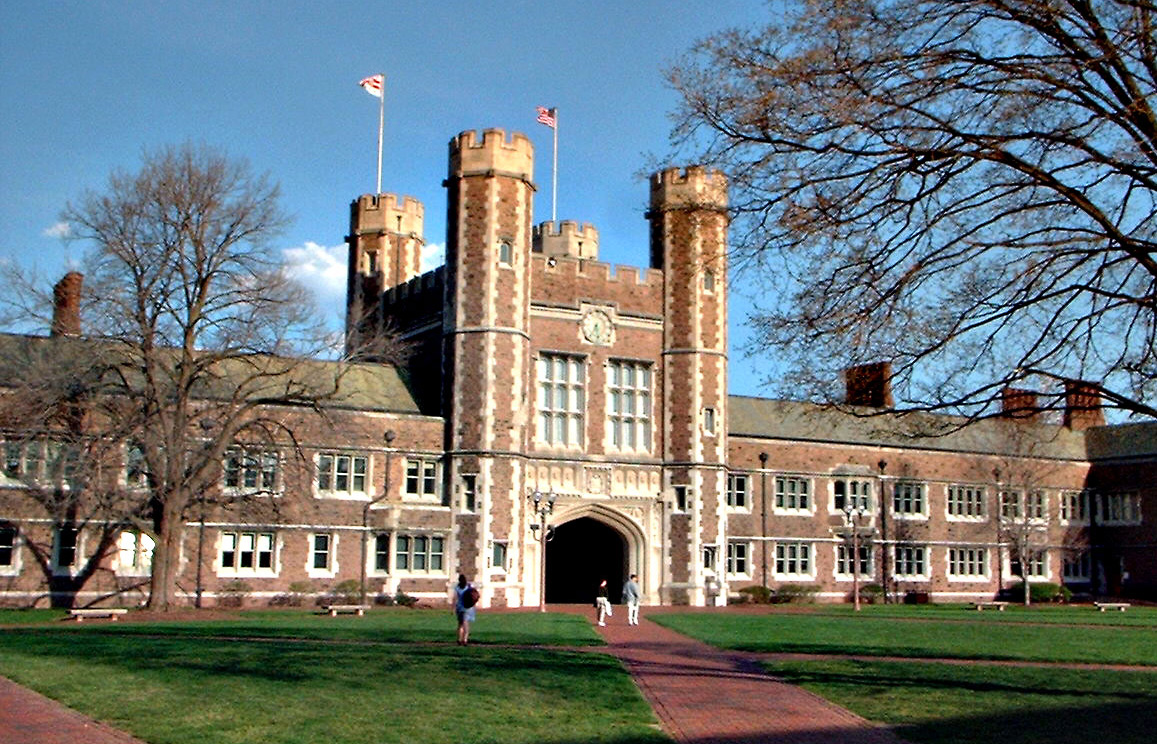

In [5]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

print(np.asarray(img))

img

# Creating Images (from pixels) in Python


Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

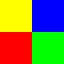

In [6]:
from PIL import Image
import numpy as np

w, h = 64, 64
data = np.zeros((h, w, 3), dtype=np.uint8)

# Yellow
for row in range(32):
    for col in range(32):
        data[row,col] = [255,255,0]
        
# Red
for row in range(32):
    for col in range(32):
        data[row+32,col] = [255,0,0]
        
# Green
for row in range(32):
    for col in range(32):
        data[row+32,col+32] = [0,255,0]        
        
# Blue
for row in range(32):
    for col in range(32):
        data[row,col+32] = [0,0,255]                
        

img = Image.fromarray(data, 'RGB')
img

# Transform Images in Python (at the pixel level)

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

Rows: 744, Cols: 1157


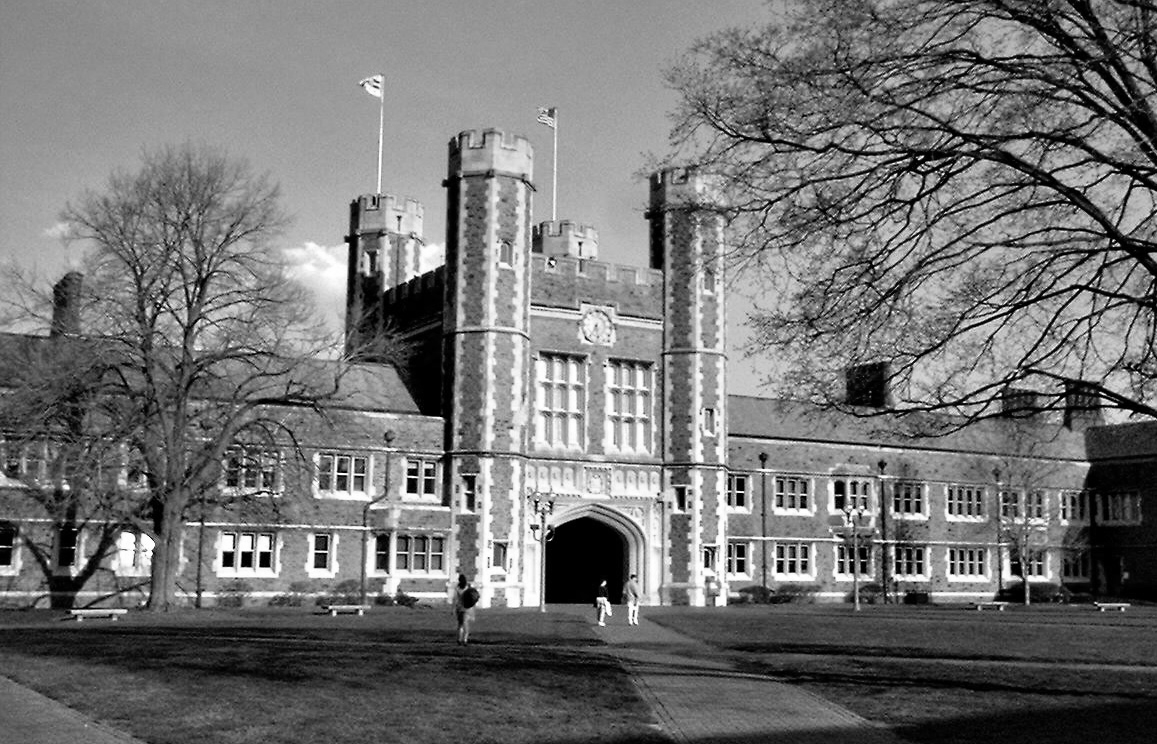

In [7]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = np.zeros((rows, cols, 3), dtype=np.uint8)
for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]

img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Auto Encode (single image)

We are now ready to build a simple image auto encoder.  The program below learns an effective encoding for the image.  You can see the distortions that occur.

49152
[[  84.  134.  177. ...,    6.   15.   14.]]
Neural network output
[[  79.24272919  150.39949036  215.61705017 ...,   29.28099251   61.705513
    52.17177963]]
[[  84.  134.  177. ...,    6.   15.   14.]]


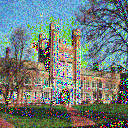

In [8]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
from keras.optimizers import SGD
import requests
from io import BytesIO

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
    
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()
img = img.resize((128,128), Image.ANTIALIAS)
img_array = np.asarray(img)
img_array = img_array.flatten()
img_array = np.array([ img_array ])
img_array = img_array.astype(np.float32)
print(img_array.shape[1])
print(img_array)

model = Sequential()
model.add(Dense(10, input_dim=img_array.shape[1], activation='relu'))
model.add(Dense(img_array.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(img_array,img_array,verbose=0,epochs=20)

print("Neural network output")
pred = model.predict(img_array)
print(pred)
print(img_array)
cols,rows = img.size
img_array2 = pred[0].reshape(rows,cols,3)
img_array2 = img_array2.astype(np.uint8)
img2 = Image.fromarray(img_array2, 'RGB')
img2   

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


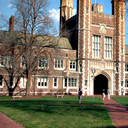

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


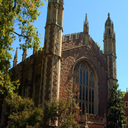

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


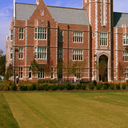

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


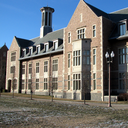

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


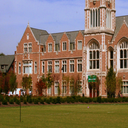

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


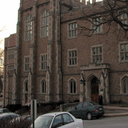

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


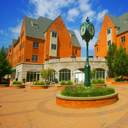

(7, 49152)


In [9]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = [] 
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/128
    x.append(img_array)
    

x = np.array(x)

print(x.shape)


# Image Auto Encoder (multi-image)

Auto encoders can learn the same encoding for multiple images.  The following code learns a single encoding for multiple images. 

Creating/Training neural network
Score neural network
[-0.14049554  0.25029761  0.58553851 ..., -0.80595076 -0.86057293
 -0.7504636 ]


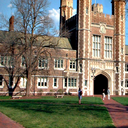

[ 0.13196078  0.05925899 -0.87959045 ..., -0.59999287 -0.77821648
 -0.93420708]


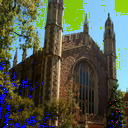

[ 0.2535702   0.38179344  0.65043229 ..., -0.05802192 -0.19710749
 -0.48277712]


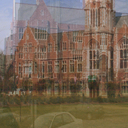

[-0.40666211  0.08594029  0.65586102 ..., -0.12605675 -0.22744958
 -0.34364808]


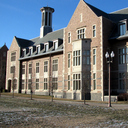

[-0.04096431  0.12873974  0.41957617 ..., -0.04479483 -0.21424906
 -0.59832722]


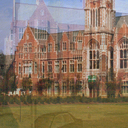

[ 0.84711808  0.88205487  1.05187273 ..., -0.10901432 -0.18808329
 -0.26786795]


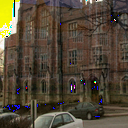

[-0.78845626 -0.38993734  0.53223598 ...,  0.6478411   0.20275952
 -0.35163575]


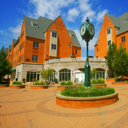

In [10]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,x,verbose=0,epochs=1000)

print("Score neural network")
pred = model.predict(x)

cols,rows = img.size
for i in range(len(pred)):
    print(pred[i])
    img_array2 = pred[i].reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    display(img2)   

# Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 744, Cols: 1157
(744, 1157, 3)


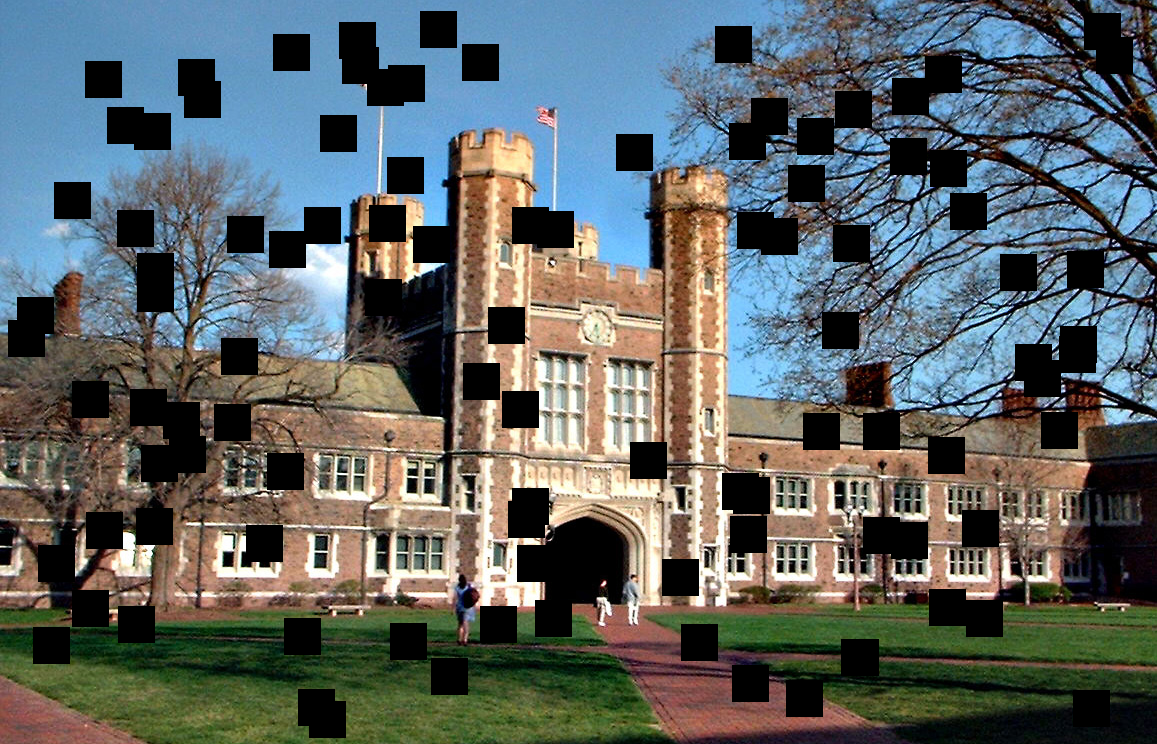

In [11]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Denoising Autoencoder

A denoising auto encoder is designed to remove noise from input signals.  To do this the $y$ becomes each image/signal (just like a normal auto encoder), however, the $x$ becomes a version of $y$ with noise added.  Noise is artificially added to the images to produce $x$.  The following code creates 10 noisy version of each of the images.  The network is trained to convert noisy data ($x$) to the origional input ($y$).

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


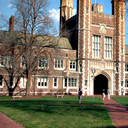

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


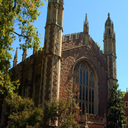

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


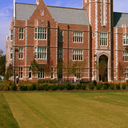

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


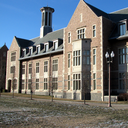

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


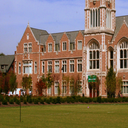

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


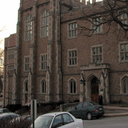

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


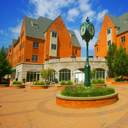

(70, 49152)
(70, 49152)


In [12]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = []    
y = []
loaded_images = []
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    
    loaded_images.append(img)
    print(url)
    display(img)
    for i in range(10):
        img_array = np.asarray(img)
        img_array_noise = add_noise(img_array)
        
        img_array = img_array.flatten()
        img_array = img_array.astype(np.float32)
        img_array = (img_array-128)/128
        
        img_array_noise = img_array_noise.flatten()
        img_array_noise = img_array_noise.astype(np.float32)
        img_array_noise = (img_array_noise-128)/128
        
        x.append(img_array_noise)
        y.append(img_array)
    
x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)


In [13]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from sklearn import metrics
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML 

# Fit regression DNN model.
print("Creating/Training neural network")
model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(x.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=1,epochs=20)

print("Neural network trained")


Creating/Training neural network
Epoch 1/20
70/70 [==============================] - 1s - loss: 0.2699     
Epoch 2/20
70/70 [==============================] - 0s - loss: 0.1991     
Epoch 3/20
70/70 [==============================] - 0s - loss: 0.1668     
Epoch 4/20
70/70 [==============================] - 0s - loss: 0.1398     
Epoch 5/20
70/70 [==============================] - 0s - loss: 0.1044     
Epoch 6/20
70/70 [==============================] - 0s - loss: 0.0667     
Epoch 7/20
70/70 [==============================] - 0s - loss: 0.0451     
Epoch 8/20
70/70 [==============================] - 0s - loss: 0.0293     
Epoch 9/20
70/70 [==============================] - 0s - loss: 0.0273     
Epoch 10/20
70/70 [==============================] - 0s - loss: 0.0184     
Epoch 11/20
70/70 [==============================] - 0s - loss: 0.0142     
Epoch 12/20
70/70 [==============================] - 0s - loss: 0.0134     
Epoch 13/20
70/70 [==============================] - 0s - loss: 

*** Trial 1
With noise:


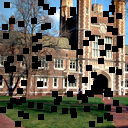

After auto encode noise removal


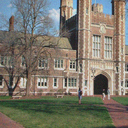

*** Trial 2
With noise:


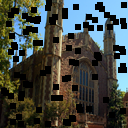

After auto encode noise removal


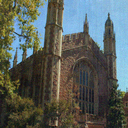

*** Trial 3
With noise:


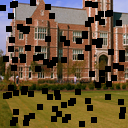

After auto encode noise removal


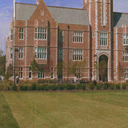

*** Trial 4
With noise:


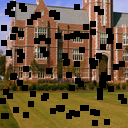

After auto encode noise removal


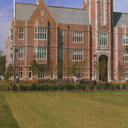

*** Trial 5
With noise:


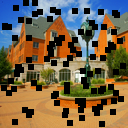

After auto encode noise removal


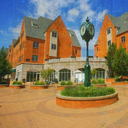

*** Trial 6
With noise:


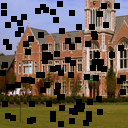

After auto encode noise removal


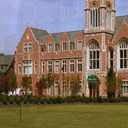

*** Trial 7
With noise:


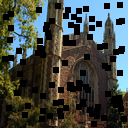

After auto encode noise removal


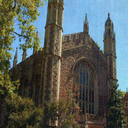

*** Trial 8
With noise:


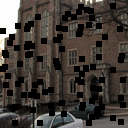

After auto encode noise removal


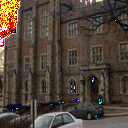

*** Trial 9
With noise:


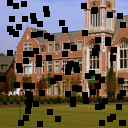

After auto encode noise removal


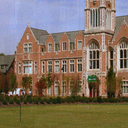

*** Trial 10
With noise:


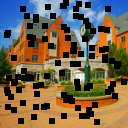

After auto encode noise removal


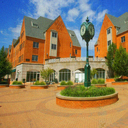

In [14]:
for z in range(10):
    print("*** Trial {}".format(z+1))
    
    # Choose random image
    i = np.random.randint(len(loaded_images))
    img = loaded_images[i]
    img_array = np.asarray(img)
    cols, rows = img.size

    # Add noise
    img_array_noise = add_noise(img_array)    

    #Display noisy image
    img2 = img_array_noise.astype(np.uint8)
    img2 = Image.fromarray(img2, 'RGB')
    print("With noise:")
    display(img2)

    # Present noisy image to auto encoder
    img_array_noise = img_array_noise.flatten()
    img_array_noise = img_array_noise.astype(np.float32)
    img_array_noise = (img_array_noise-128)/128
    img_array_noise = np.array([img_array_noise])
    pred = model.predict(img_array_noise)[0]

    # Display neural result
    img_array2 = pred.reshape(rows,cols,3)
    img_array2 = (img_array2*128)+128
    img_array2 = img_array2.astype(np.uint8)
    img2 = Image.fromarray(img_array2, 'RGB')
    print("After auto encode noise removal")
    display(img2)

# Neural Network Ensembles

The following sections describe how to create ensembles of neural networks and other model types.

# LogLoss Error

Log loss is an error metric that is often used in place of accuracy for classification.  Log loss allows for "partial credit" when a miss classification occurs.  For example, a model might be used to classify A, B and C.  The correct answer might be A, however if the classification network chose B as having the highest probability, then accuracy gives the neural network no credit for this classification.  

However, with log loss, the probability of the correct answer is added to the score.  For example, the correct answer might be A, but if the neural network only predicted .8 probability of A being correct, then the value -log(.8) is added.

$$ logloss = -\frac{1}{N}\sum^N_{i=1}\sum^M_{j=1}y_{ij} \log(\hat{y}_{ij}) $$

The following table shows the logloss scores that correspond to the average predicted accuracy for the correct item. The **pred** column specifies the average probability for the correct class.  The **logloss** column specifies the log loss for that probability.


In [15]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

loss = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025, 1e-8 ]

df = pd.DataFrame({'pred':loss, 'logloss': -np.log(loss)},columns=['pred','logloss'])

display(df)

pred    logloss
0   1.000000e+00  -0.000000
1   9.000000e-01   0.105361
2   8.000000e-01   0.223144
3   7.000000e-01   0.356675
4   6.000000e-01   0.510826
5   5.000000e-01   0.693147
6   4.000000e-01   0.916291
7   3.000000e-01   1.203973
8   2.000000e-01   1.609438
9   1.000000e-01   2.302585
10  7.500000e-02   2.590267
11  5.000000e-02   2.995732
12  2.500000e-02   3.688879
13  1.000000e-08  18.420681

The table below shows the opposit.  For a given logloss, what is the average probability for the correct class.

In [16]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

loss = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 3.5, 4 ]

df = pd.DataFrame({'logloss':loss, 'pred': np.exp(np.negative(loss))},
                  columns=['logloss','pred'])

display(df)

logloss      pred
0       0.1  0.904837
1       0.2  0.818731
2       0.3  0.740818
3       0.4  0.670320
4       0.5  0.606531
5       0.6  0.548812
6       0.7  0.496585
7       0.8  0.449329
8       0.9  0.406570
9       1.0  0.367879
10      1.5  0.223130
11      2.0  0.135335
12      2.5  0.082085
13      3.0  0.049787
14      3.5  0.030197
15      4.0  0.018316

# Evaluating Feature Importance

Feature importance tells us how important each of the features (from the feature/import vector are to the prediction of a neural network, or other model.  There are many different ways to evaluate feature importance for neural networks.  The following paper presents a very good (and readable) overview of the various means of evaluating the importance of neural network inputs/features.

Olden, J. D., Joy, M. K., & Death, R. G. (2004). [An accurate comparison of methods for quantifying variable importance in artificial neural networks using simulated data](http://depts.washington.edu/oldenlab/wordpress/wp-content/uploads/2013/03/EcologicalModelling_2004.pdf). *Ecological Modelling*, 178(3), 389-397.

In summary, the following methods are available to neural networks:

* Connection Weights Algorithm
* Partial Derivatives
* Input Perturbation
* Sensitivity Analysis
* Forward Stepwise Addition 
* Improved Stepwise Selection 1
* Backward Stepwise Elimination
* Improved Stepwise Selection

For this class we will use the **Input Perturbation** feature ranking algorithm.  This algorithm will work with any regression or classification network.  implementation of the input perturbation algorithm for scikit-learn is given in the next section. This algorithm is implemented in a function below that will work with any scikit-learn model.

This algorithm was introduced by [Breiman](https://en.wikipedia.org/wiki/Leo_Breiman) in his seminal paper on random forests.  Although he presented this algorithm in conjunction with random forests, it is model-independent and appropriate for any supervised learning model.  This algorithm, known as the input perturbation algorithm, works by evaluating a trained model’s accuracy with each of the inputs individually shuffled from a data set.  Shuffling an input causes it to become useless—effectively removing it from the model. More important inputs will produce a less accurate score when they are removed by shuffling them. This process makes sense, because important features will contribute to the accuracy of the model.  The TensorFlow version of this algorithm is taken from the following paper.

Heaton, J., McElwee, S., & Cannady, J. (May 2017). Early stabilizing feature importance for TensorFlow deep neural networks. In *International Joint Conference on Neural Networks (IJCNN 2017)* (accepted for publication). IEEE.

This algorithm will use logloss to evaluate a classification problem and RMSE for regression.

In [17]:
from sklearn import metrics
import scipy as sp
import numpy as np
import math
from sklearn import metrics

def perturbation_rank(model, x, y, names, regression):
    errors = []

    for i in range(x.shape[1]):
        hold = np.array(x[:, i])
        np.random.shuffle(x[:, i])
        
        if regression:
            pred = model.predict(x)
            error = metrics.mean_squared_error(y, pred)
        else:
            pred = model.predict_proba(x)
            error = metrics.log_loss(y, pred)
            
        errors.append(error)
        x[:, i] = hold
        
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]

    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data, columns = ['name','error','importance'])
    result.sort_values(by=['importance'], ascending=[0], inplace=True)
    result.reset_index(inplace=True, drop=True)
    return result

### Classification Input Perturbation Ranking

In [18]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)


Epoch 00668: early stopping


In [19]:
# Rank the features
from IPython.display import display, HTML

names = list(df.columns) # x+y column names
names.remove("species") # remove the target(y)
rank = perturbation_rank(model, x_test, y_test, names, False)
display(rank)

32/38 [========================>.....] - ETA: 0s

name     error  importance
0  petal_l  1.674847    1.000000
1  petal_w  1.357398    0.810461
2  sepal_w  0.128309    0.076609
3  sepal_l  0.115371    0.068885

### Regression Input Perturbation Ranking

In [20]:
# Rank MPG fields

import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
    

Epoch 00472: early stopping


In [21]:
# Rank the features
from IPython.display import display, HTML

names = list(df.columns) # x+y column names
names.remove("mpg") # remove the target(y)
rank = perturbation_rank(model, x_test, y_test, names, True)
display(rank)

name      error  importance
0        weight  20.300335    1.000000
1    horsepower  20.283270    0.999159
2          year  14.475515    0.713068
3  displacement   9.091635    0.447856
4      origin-2   7.627264    0.375721
5  acceleration   7.505361    0.369716
6     cylinders   7.465614    0.367758
7      origin-1   7.396411    0.364349
8      origin-3   7.244848    0.356883

# The Biological Response Data Set

* [Biological Response Dataset at Kaggle](https://www.kaggle.com/c/bioresponse)
* [1st place interview for Boehringer Ingelheim Biological Response](http://blog.kaggle.com/2012/07/05/1st-place-interview-for-boehringer-ingelheim-biological-response/)

In [22]:
import tensorflow.contrib.learn as skflow
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from IPython.display import HTML, display

path = "./data/"

filename_train = os.path.join(path,"bio_train.csv")
filename_test = os.path.join(path,"bio_test.csv")
filename_submit = os.path.join(path,"bio_submit.csv")
df_train = pd.read_csv(filename_train,na_values=['NA','?'])
df_test = pd.read_csv(filename_test,na_values=['NA','?'])

activity_classes = encode_text_index(df_train,'Activity')

#display(df_train)

In [23]:
print(df_train.shape)

(3751, 1777)


### Biological Response with Neural Network

In [24]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow.contrib.learn as skflow
import numpy as np
import sklearn

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

# Encode feature vector
x, y = to_xy(df_train,'Activity')
x_submit = df_test.as_matrix().astype(np.float32)
num_classes = len(activity_classes)

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42) 

print("Fitting/Training...")
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
print("Fitting done...")

# Give logloss error
pred = model.predict(x_test)
pred2 = np.argmax(pred,axis=1)
pred = pred[:,1]
# Clip so that min is never exactly 0, max never 1
pred = np.clip(pred,a_min=1e-6,a_max=(1-1e-6)) 
print("Validation logloss: {}".format(sklearn.metrics.log_loss(y_test,pred)))

# Evaluate success using accuracy
pred_submit = pred.copy()
y_test = y_test[:,1]
score = metrics.accuracy_score(y_test, pred2)
print("Validation accuracy score: {}".format(score))

# Build real submit file
pred_submit = model.predict(x_submit)
pred_submit = pred_submit[:,1]

# Clip so that min is never exactly 0, max never 1
pred = np.clip(pred,a_min=1e-6,a_max=(1-1e-6)) 
submit_df = pd.DataFrame({'MoleculeId':[x+1 for x in range(len(pred_submit))],'PredictedProbability':pred_submit})
submit_df.to_csv(filename_submit, index=False)


Fitting/Training...
Epoch 00007: early stopping
Fitting done...
Validation logloss: 0.6036497835400113
Validation accuracy score: 0.7611940298507462


# What Features/Columns are Important 

The following uses perturbation ranking to evaluate the neural network.

In [25]:
# Rank the features
from IPython.display import display, HTML

names = list(df_train.columns) # x+y column names
names.remove("Activity") # remove the target(y)
rank = perturbation_rank(model, x_test, y_test, names, False)
display(rank)

 32/938 [>.............................] - ETA: 0s

name     error  importance
0       D27  0.650498    1.000000
1     D1059  0.616778    0.948163
2     D1100  0.613654    0.943360
3       D51  0.613054    0.942439
4      D119  0.610269    0.938157
5     D1203  0.609693    0.937272
6     D1009  0.609679    0.937249
7     D1071  0.609667    0.937232
8     D1096  0.609410    0.936836
9     D1153  0.609259    0.936604
10    D1241  0.608215    0.934999
11     D992  0.607898    0.934512
12     D958  0.607712    0.934226
13    D1049  0.607670    0.934161
14    D1390  0.607634    0.934106
15    D1127  0.607430    0.933792
16    D1392  0.607420    0.933777
17    D1271  0.607402    0.933749
18    D1025  0.607274    0.933553
19    D1194  0.607265    0.933540
20    D1371  0.607116    0.933310
21    D1158  0.607066    0.933233
22    D1407  0.606930    0.933025
23    D1026  0.606892    0.932965
24    D1067  0.606808    0.932837
25    D1093  0.606720    0.932701
26    D1418  0.606706    0.932680
27    D1167  0.606682    0.932642
28     D469  0.606598    0.932514
29    D1147  0.606597    0.932512
...     ...       ...         ...
1746  D1434  0.601318    0.924396
1747  D1314  0.601303    0.924374
1748  D1014  0.601289    0.924353
1749  D1681  0.601270    0.924323
1750  D1551  0.601232    0.924265
1751  D1376  0.601092    0.924049
1752  D1078  0.601082    0.924034
1753  D1200  0.601073    0.924020
1754  D1141  0.601053    0.923989
1755   D125  0.601050    0.923984
1756  D1064  0.601018    0.923935
1757   D982  0.600981    0.923879
1758   D127  0.600952    0.923833
1759  D1305  0.600907    0.923765
1760   D988  0.600756    0.923533
1761  D1405  0.600755    0.923531
1762  D1404  0.600734    0.923499
1763  D1182  0.600732    0.923496
1764   D959  0.600715    0.923469
1765  D1294  0.600484    0.923115
1766  D1275  0.600410    0.923001
1767  D1095  0.600398    0.922982
1768  D1442  0.600174    0.922637
1769   D997  0.599845    0.922132
1770  D1415  0.599411    0.921464
1771  D1027  0.599377    0.921413
1772  D1225  0.599126    0.921027
1773  D1309  0.599049    0.920909
1774  D1043  0.598261    0.919697
1775  D1075  0.596885    0.917581

[1776 rows x 3 columns]

# Neural Network Ensemble

A neural network ensemble combines neural network predictions with other models.  The exact blend of all of these models is determined by logistic regression.  The following code performs this blend for a classification.

In [26]:
import numpy as np
import os
import pandas as pd
import math
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

PATH = "./data/"
SHUFFLE = False
FOLDS = 10

def build_ann(input_size,classes,neurons):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_size, activation='relu'))
    model.add(Dense(1))
    model.add(Dense(classes,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

def mlogloss(y_test, preds):
    epsilon = 1e-15
    sum = 0
    for row in zip(preds,y_test):
        x = row[0][row[1]]
        x = max(epsilon,x)
        x = min(1-epsilon,x)
        sum+=math.log(x)
    return( (-1/len(preds))*sum)

def stretch(y):
    return (y - y.min()) / (y.max() - y.min())


def blend_ensemble(x, y, x_submit):

    folds = list(StratifiedKFold(y, FOLDS))
    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]

    models = [
        KerasClassifier(build_fn=build_ann,neurons=20,input_size=x.shape[1],classes=2),
        KNeighborsClassifier(n_neighbors=3),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50)]

    dataset_blend_train = np.zeros((x.shape[0], len(models)))
    dataset_blend_test = np.zeros((x_submit.shape[0], len(models)))

    for j, model in enumerate(models):
        print("Model: {} : {}".format(j, model) )
        fold_sums = np.zeros((x_submit.shape[0], len(folds)))
        total_loss = 0
        for i, (train, test) in enumerate(folds):
            x_train = x[train]
            y_train = y[train]
            x_test = x[test]
            y_test = y[test]
            model.fit(x_train, y_train)
            pred = np.array(model.predict_proba(x_test))
            # pred = model.predict_proba(x_test)
            dataset_blend_train[test, j] = pred[:, 1]
            pred2 = np.array(model.predict_proba(x_submit))
            #fold_sums[:, i] = model.predict_proba(x_submit)[:, 1]
            fold_sums[:, i] = pred2[:, 1]
            loss = mlogloss(y_test, pred)
            total_loss+=loss
            print("Fold #{}: loss={}".format(i,loss))
        print("{}: Mean loss={}".format(model.__class__.__name__,total_loss/len(folds)))
        dataset_blend_test[:, j] = fold_sums.mean(1)

    print()
    print("Blending models.")
    blend = LogisticRegression()
    blend.fit(dataset_blend_train, y)
    return blend.predict_proba(dataset_blend_test)

if __name__ == '__main__':

    np.random.seed(42)  # seed to shuffle the train set

    print("Loading data...")
    filename_train = os.path.join(PATH, "bio_train.csv")
    df_train = pd.read_csv(filename_train, na_values=['NA', '?'])

    filename_submit = os.path.join(PATH, "bio_test.csv")
    df_submit = pd.read_csv(filename_submit, na_values=['NA', '?'])

    predictors = list(df_train.columns.values)
    predictors.remove('Activity')
    x = df_train.as_matrix(predictors)
    y = df_train['Activity']
    x_submit = df_submit.as_matrix()

    if SHUFFLE:
        idx = np.random.permutation(y.size)
        x = x[idx]
        y = y[idx]

    submit_data = blend_ensemble(x, y, x_submit)
    submit_data = stretch(submit_data)

    ####################
    # Build submit file
    ####################
    ids = [id+1 for id in range(submit_data.shape[0])]
    submit_filename = os.path.join(PATH, "bio_submit.csv")
    submit_df = pd.DataFrame({'MoleculeId': ids, 'PredictedProbability': submit_data[:, 1]},
                             columns=['MoleculeId','PredictedProbability'])
    submit_df.to_csv(submit_filename, index=False)

C:\Users\jeffh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading data...
Model: 0 : <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000015A80B1CFD0>
Epoch 1/10
3375/3375 [==============================] - 0s - loss: 0.6026     
Epoch 2/10
3375/3375 [==============================] - 0s - loss: 0.4854     
Epoch 3/10
3375/3375 [==============================] - 0s - loss: 0.4476     
Epoch 4/10
3375/3375 [==============================] - 0s - loss: 0.4168     
Epoch 5/10
3375/3375 [==============================] - 0s - loss: 0.3982     
Epoch 6/10
3375/3375 [==============================] - 0s - loss: 0.3745     
Epoch 7/10
3375/3375 [==============================] - 0s - loss: 0.3643     
Epoch 8/10
3375/3375 [==============================] - 0s - loss: 0.3409     
Epoch 9/10
3375/3375 [==============================] - 0s - loss: 0.3443     
Epoch 10/10
2432/2501 [============================>.] - ETA: 0sFold #0: loss=0.5692784714735876
Epoch 1/10
3375/3375 [==============================] - 0s - loss: 0.6160     
Epoch 2/10


3377/3377 [==============================] - 0s - loss: 0.4421     
Epoch 4/10
3377/3377 [==============================] - 0s - loss: 0.4194     
Epoch 5/10
3377/3377 [==============================] - 0s - loss: 0.3878     
Epoch 6/10
3377/3377 [==============================] - 0s - loss: 0.3639     
Epoch 7/10
3377/3377 [==============================] - 0s - loss: 0.3446     
Epoch 8/10
3377/3377 [==============================] - 0s - loss: 0.3429     
Epoch 9/10
3377/3377 [==============================] - 0s - loss: 0.3109     
Epoch 10/10
2112/2501 [========================>.....] - ETA: 0sFold #9: loss=0.682065415897285
KerasClassifier: Mean loss=0.5606905594779371
Model: 1 : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Fold #0: loss=3.606678388314123
Fold #1: loss=2.2197228940978317
Fold #2: loss=3.6717523663107237
Fold #3: loss=2.5045156203944594
Fold #4: l